In [81]:
import pandas as pd

In [82]:
def parse_weights_string(weights_str):
    weights_str = weights_str.replace("[", "").replace("]", "").replace("\r\n", "").replace(",", " ").strip()  # Remove unwanted characters
    weights_list = [float(w) for w in weights_str.split()]  # Split and convert elements to float
    return weights_list

In [83]:
# obtain 63-day price movement for each ticker
stock_data = pd.read_csv('SP500_stock_prices.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data[stock_data['Date'] >= '2019-10-01']
stock_data = stock_data[stock_data['Date'] <= '2020-04-02']
stock_data = stock_data[['Date', 'Ticker', 'Close']]
# Make Date the index
stock_data = stock_data.set_index('Date')
# make the index to be the date
stock_data.index = pd.to_datetime(stock_data.index)

# Calculate returns over 63 business days
# select only the ticker index
indiviual_datas = []

for ticker in stock_data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = stock_data[stock_data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['63-day Price Movement'] = data_ticker['Close'].pct_change(63).shift(-63)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)
data_all_tickers

,Ticker,Close,63-day Price Movement
Date,,,
2019-10-01,MMM,158.380005,0.113903
2019-10-02,MMM,155.649994,0.156441
2019-10-03,MMM,155.229996,0.149584
2019-10-04,MMM,155.820007,0.146323
2019-10-07,MMM,153.520004,0.158807
...,...,...,...
2019-12-24,ZTS,132.919998,-0.112925
2019-12-26,ZTS,133.029999,-0.159814
2019-12-27,ZTS,133.250000,-0.124353


Test 1:

In [84]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_1 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_1ddh.csv', index_col=0)

# rename the columns
LSTM_results_1.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_1)):
    LSTM_results_1['Optimal Weights'][i] = parse_weights_string(LSTM_results_1['Optimal Weights'][i])

# make the index to be the date
LSTM_results_1.index = pd.to_datetime(LSTM_results_1.index)

optimal_weights_dict_1 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_1.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_1[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_1 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_1.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_1 = stock_returns_1.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_1['Weighted Returns'] = stock_returns_1['Weight'] * stock_returns_1['63-day Price Movement']
# remove all rows with NaN values
stock_returns_1.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_1 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_1.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_1:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_1[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_1[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_1['Actual Returns (%)'] = LSTM_results_1.index.map(portfolio_returns_dict_1)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_1['Actual Returns (%)'] = LSTM_results_1['Actual Returns (%)'] * 100
LSTM_results_1['Estimated Return'] = LSTM_results_1['Estimated Return'] * 100
LSTM_results_1['Estimated Risk'] = LSTM_results_1['Estimated Risk'] * 100
# Rename the columns
LSTM_results_1.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_1

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3809954857.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_1['Optimal Weights'][i] = parse_weights_string(LSTM_results_1['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'PAYX', 'GRMN', 'KMI', 'DVA', 'COP', ...","[0.44873372, 0.16254446, 0.1182308, 0.05755858...",11.139745,7.111721,16.848819
2019-10-02,"['ALLE', 'SWK', 'VRSK', 'DUK', 'BDX', 'DRI', '...","[0.54692371, 0.14765443, 0.11179518, 0.0592047...",13.627686,7.773298,17.320830
2019-10-03,"['ALLE', 'ECL', 'DGX', 'UDR', 'ARE', 'SYK', 'R...","[0.45209839, 0.16139644, 0.13077886, 0.0827430...",12.901586,5.867972,10.491558
2019-10-04,"['ALLE', 'EPAM', 'J', 'ZBRA', 'MSCI', 'NTAP', ...","[0.38192856, 0.1996291, 0.12191819, 0.06758953...",15.271164,7.415197,16.335335
2019-10-07,"['ALLE', 'PAYC', 'NEE', 'CMCSA', 'BK', 'CL', '...","[0.44771114, 0.13587717, 0.11252307, 0.0982289...",15.474050,8.674307,15.181310
...,...,...,...,...,...
2019-12-23,"['FISV', 'MSCI', 'ROST', 'NFLX', 'SO', 'ZTS', ...","[0.35192268, 0.26805046, 0.13070365, 0.0816209...",6.164167,7.926036,-6.044887
2019-12-24,"['GNRC', 'AFL', 'IQV', 'SO', 'AAPL', 'WST', 'R...","[0.28362538, 0.22004477, 0.14066235, 0.0824969...",5.652449,6.973425,-15.171956
2019-12-26,"['GNRC', 'AEE', 'PGR', 'MMC', 'HAL', 'CPRT', '...","[0.41311728, 0.1523635, 0.12935536, 0.08625532...",5.462270,8.147887,-15.734613


In [85]:
# calculate mean and median of actual returns and print them
mean_actual_returns_1 = LSTM_results_1['Actual Returns (%)'].mean()
median_actual_returns_1 = LSTM_results_1['Actual Returns (%)'].median()
print(f"Mean Actual Returns: {mean_actual_returns_1}")
print(f"Median Actual Returns: {median_actual_returns_1}")

Mean Actual Returns: 7.199834120413318
Median Actual Returns: 11.268864998663688


Test 2:

In [86]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_2 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_1ddhh.csv', index_col=0)

# rename the columns
LSTM_results_2.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_2)):
    LSTM_results_2['Optimal Weights'][i] = parse_weights_string(LSTM_results_2['Optimal Weights'][i])

# make the index to be the date
LSTM_results_2.index = pd.to_datetime(LSTM_results_2.index)

optimal_weights_dict_2 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_2.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_2[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_2 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_2.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_2 = stock_returns_2.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_2['Weighted Returns'] = stock_returns_2['Weight'] * stock_returns_2['63-day Price Movement']
# remove all rows with NaN values
stock_returns_2.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_2 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_2.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_2:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_2[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_2[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_2['Actual Returns (%)'] = LSTM_results_2.index.map(portfolio_returns_dict_2)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_2['Actual Returns (%)'] = LSTM_results_2['Actual Returns (%)'] * 100
LSTM_results_2['Estimated Return'] = LSTM_results_2['Estimated Return'] * 100
LSTM_results_2['Estimated Risk'] = LSTM_results_2['Estimated Risk'] * 100
# Rename the columns
LSTM_results_2.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_2

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\796174146.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_2['Optimal Weights'][i] = parse_weights_string(LSTM_results_2['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'MA', 'K', 'FLT', 'GRMN', 'REGN', 'PN...","[0.39680374, 0.14784348, 0.12327637, 0.1219125...",12.243361,6.693681,16.451730
2019-10-02,"['ALLE', 'ALGN', 'ABC', 'AXP', 'ALB', 'MPC', '...","[0.54674769, 0.11262721, 0.10615922, 0.0888638...",15.303195,8.963047,22.786293
2019-10-03,"['ALLE', 'TMO', 'JNJ', 'AMP', 'INTU', 'ELV', '...","[0.27446709, 0.1533131, 0.15179603, 0.14197828...",14.197620,5.780114,17.429038
2019-10-04,"['ALLE', 'ATO', 'TT', 'BWA', 'EIX', 'ENPH', 'O...","[0.47606435, 0.11722658, 0.10105151, 0.0807621...",16.484333,6.781060,13.477839
2019-10-07,"['ALLE', 'ODFL', 'COF', 'DFS', 'TMUS', 'ORCL',...","[0.43938816, 0.21533654, 0.06996487, 0.0536948...",13.519023,7.698616,13.866784
...,...,...,...,...,...
2019-12-23,"['GNRC', 'MKTX', 'CINF', 'DG', 'NEE', 'LMT', '...","[0.33851819, 0.23978735, 0.09933631, 0.0914610...",7.137393,7.638391,-14.876695
2019-12-24,"['ENPH', 'COST', 'DG', 'AMD', 'NFLX', 'IFF', '...","[0.25829274, 0.17183329, 0.1539772, 0.11243571...",11.257679,15.954137,5.175009
2019-12-26,"['FISV', 'AMT', 'FICO', 'TT', 'MKC', 'EPAM', '...","[0.37759408, 0.20971421, 0.20436115, 0.0594251...",5.474322,7.106990,-10.607633


In [87]:
# calculate mean and median of actual returns and print them
mean_actual_returns_2 = LSTM_results_2['Actual Returns (%)'].mean()
median_actual_returns_2 = LSTM_results_2['Actual Returns (%)'].median()
print(f"Test 2: Mean Actual Returns: {mean_actual_returns_2}")
print(f"Test 2: Median Actual Returns: {median_actual_returns_2}")

Test 2: Mean Actual Returns: 7.928842426685101
Test 2: Median Actual Returns: 10.680477651006363


Test 3:

In [88]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_3 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_1dh.csv', index_col=0)

# rename the columns
LSTM_results_3.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_3)):
    LSTM_results_3['Optimal Weights'][i] = parse_weights_string(LSTM_results_3['Optimal Weights'][i])

# make the index to be the date
LSTM_results_3.index = pd.to_datetime(LSTM_results_3.index)

optimal_weights_dict_3 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_3.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_3[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_3 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_3.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_3 = stock_returns_3.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_3['Weighted Returns'] = stock_returns_3['Weight'] * stock_returns_3['63-day Price Movement']
# remove all rows with NaN values
stock_returns_3.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_3 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_3.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_3:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_3[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_3[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_3['Actual Returns (%)'] = LSTM_results_3.index.map(portfolio_returns_dict_3)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_3['Actual Returns (%)'] = LSTM_results_3['Actual Returns (%)'] * 100
LSTM_results_3['Estimated Return'] = LSTM_results_3['Estimated Return'] * 100
LSTM_results_3['Estimated Risk'] = LSTM_results_3['Estimated Risk'] * 100
# Rename the columns
LSTM_results_3.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_3

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3404241110.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_3['Optimal Weights'][i] = parse_weights_string(LSTM_results_3['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'GOOG', 'ITW', 'RMD', 'WAT', 'ABT', '...","[0.32293359, 0.13176965, 0.13154076, 0.0953651...",8.619735,5.621249,14.113361
2019-10-02,"['ALLE', 'SBUX', 'MCK', 'OKE', 'TFX', 'MSFT', ...","[0.48364647, 0.13156679, 0.12500244, 0.0868130...",12.471542,7.997130,16.648339
2019-10-03,"['ALLE', 'FISV', 'WBA', 'TXN', 'FIS', 'HAS', '...","[0.29805118, 0.25130466, 0.14623946, 0.1272755...",9.874548,6.209276,9.010557
2019-10-04,"['ALLE', 'GRMN', 'EXC', 'ORLY', 'CFG', 'SWK', ...","[0.40286559, 0.15063352, 0.12272685, 0.0753593...",12.425645,5.667414,13.182535
2019-10-07,"['ALLE', 'NEE', 'CME', 'MTB', 'GPN', 'WRB', 'C...","[0.2648988, 0.19030157, 0.18750749, 0.17425841...",10.631936,4.896844,7.246885
...,...,...,...,...,...
2019-12-23,"['ETR', 'GRMN', 'VRSN', 'ENPH', 'CDW', 'TDY', ...","[0.21474371, 0.20259831, 0.13473745, 0.1255692...",7.186034,8.611193,-17.066894
2019-12-24,"['LMT', 'PODD', 'ENPH', 'ZTS', 'RSG', 'SBAC', ...","[0.2732717, 0.23619176, 0.21680714, 0.12566142...",8.754296,15.453034,2.636770
2019-12-26,"['GNRC', 'LLY', 'NEE', 'EXPD', 'RJF', 'ANET', ...","[0.38579019, 0.1667766, 0.15104172, 0.09276526...",4.791524,7.845411,-11.480108


In [89]:
# calculate mean and median of actual returns and print them
mean_actual_returns_3 = LSTM_results_3['Actual Returns (%)'].mean()
median_actual_returns_3 = LSTM_results_3['Actual Returns (%)'].median()
print(f"Test 3: Mean Actual Returns: {mean_actual_returns_3}")
print(f"Test 3: Median Actual Returns: {median_actual_returns_3}")

Test 3: Mean Actual Returns: 6.283450624910457
Test 3: Median Actual Returns: 9.227544737783786


Test 4:

In [90]:
# load in the LSTM_results.csv file
LSTM_results_4 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_1dhh.csv', index_col=0)

# rename the columns
LSTM_results_4.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_4)):
    LSTM_results_4['Optimal Weights'][i] = parse_weights_string(LSTM_results_4['Optimal Weights'][i])

# make the index to be the date
LSTM_results_4.index = pd.to_datetime(LSTM_results_4.index)

optimal_weights_dict_4 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_4.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_4[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_4 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_4.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_4 = stock_returns_4.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_4['Weighted Returns'] = stock_returns_4['Weight'] * stock_returns_4['63-day Price Movement']
# remove all rows with NaN values
stock_returns_4.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_4 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_4.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_4:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_4[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_4[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_4['Actual Returns (%)'] = LSTM_results_4.index.map(portfolio_returns_dict_4)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_4['Actual Returns (%)'] = LSTM_results_4['Actual Returns (%)'] * 100
LSTM_results_4['Estimated Return'] = LSTM_results_4['Estimated Return'] * 100
LSTM_results_4['Estimated Risk'] = LSTM_results_4['Estimated Risk'] * 100
# Rename the columns
LSTM_results_4.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_4

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\2050938022.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_4['Optimal Weights'][i] = parse_weights_string(LSTM_results_4['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'ESS', 'EL', 'HES', 'SBUX', 'NRG', 'B...","[0.58194811, 0.1096926, 0.105634, 0.08097254, ...",14.462048,7.840893,15.055580
2019-10-02,"['ALLE', 'GILD', 'MET', 'DHI', 'HOLX', 'UHS', ...","[0.42796793, 0.20933609, 0.12377839, 0.0819346...",10.827137,7.874667,15.492445
2019-10-03,"['ALLE', 'AJG', 'REGN', 'MA', 'EPAM', 'LKQ', '...","[0.37840509, 0.12704652, 0.12211236, 0.1188712...",15.951689,6.413198,18.700954
2019-10-04,"['ALLE', 'EXR', 'PM', 'MRK', 'LRCX', 'K', 'ANE...","[0.50716564, 0.15482376, 0.09338479, 0.0639080...",14.865539,6.740106,12.078045
2019-10-07,"['ALLE', 'CHTR', 'GOOG', 'STZ', 'L', 'FCX', 'N...","[0.48491972, 0.16926495, 0.09252907, 0.0833527...",15.290664,7.479144,15.610769
...,...,...,...,...,...
2019-12-23,"['GNRC', 'FISV', 'YUM', 'GPN', 'WDC', 'GIS', '...","[0.36261092, 0.2332614, 0.16516553, 0.0533246,...",6.371451,7.450708,-14.657698
2019-12-24,"['GNRC', 'AAPL', 'ODFL', 'ENPH', 'ABC', 'TFC',...","[0.29448868, 0.19423919, 0.16224152, 0.1229527...",7.868595,11.496746,-1.500223
2019-12-26,"['PLD', 'ENPH', 'KLAC', 'NFLX', 'CL', 'CLX', '...","[0.27114468, 0.26590796, 0.11339074, 0.0909970...",9.336482,15.169232,-1.918713


In [91]:
# calculate mean and median of actual returns and print them
mean_actual_returns_4 = LSTM_results_4['Actual Returns (%)'].mean()
median_actual_returns_4 = LSTM_results_4['Actual Returns (%)'].median()
print(f"Test 4: Mean Actual Returns: {mean_actual_returns_4}")
print(f"Test 4: Median Actual Returns: {median_actual_returns_4}")

Test 4: Mean Actual Returns: 8.030851107226985
Test 4: Median Actual Returns: 11.659187079325148


Test 5:

In [92]:
# load in the LSTM_results.csv file
LSTM_results_5 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_2ddh.csv', index_col=0)

# rename the columns
LSTM_results_5.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_5)):
    LSTM_results_5['Optimal Weights'][i] = parse_weights_string(LSTM_results_5['Optimal Weights'][i])

# make the index to be the date
LSTM_results_5.index = pd.to_datetime(LSTM_results_5.index)

optimal_weights_dict_5 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_5.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_5[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_5 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_5.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_5 = stock_returns_5.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_5['Weighted Returns'] = stock_returns_5['Weight'] * stock_returns_5['63-day Price Movement']
# remove all rows with NaN values
stock_returns_5.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_5 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_5.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_5:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_5[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_5[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_5['Actual Returns (%)'] = LSTM_results_5.index.map(portfolio_returns_dict_5)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_5['Actual Returns (%)'] = LSTM_results_5['Actual Returns (%)'] * 100
LSTM_results_5['Estimated Return'] = LSTM_results_5['Estimated Return'] * 100
LSTM_results_5['Estimated Risk'] = LSTM_results_5['Estimated Risk'] * 100
# Rename the columns
LSTM_results_5.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_5

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\108248802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_5['Optimal Weights'][i] = parse_weights_string(LSTM_results_5['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'DVA', 'BXP', 'ICE', 'RMD', 'MKC', 'W...","[0.56737985, 0.08284081, 0.07669472, 0.0744771...",14.651917,7.014693,18.773847
2019-10-02,"['SYY', 'ALLE', 'INTU', 'ENPH', 'DIS', 'ALL', ...","[0.31003186, 0.25619957, 0.1051172, 0.10428856...",11.704767,7.806080,14.946524
2019-10-03,"['ALLE', 'PM', 'CPT', 'ECL', 'JKHY', 'MAA', 'C...","[0.49921408, 0.12651082, 0.10660913, 0.0971934...",14.574337,6.432672,12.433069
2019-10-04,"['ALLE', 'PPG', 'ENPH', 'CPT', 'TFX', 'WEC', '...","[0.33474722, 0.15056974, 0.12277197, 0.1205942...",14.627160,8.057934,11.498783
2019-10-07,"['ALLE', 'FIS', 'SWK', 'ABBV', 'GPC', 'SHW', '...","[0.5636095, 0.15602164, 0.06240396, 0.05035722...",17.123134,6.850638,14.653289
...,...,...,...,...,...
2019-12-23,"['NEE', 'PEG', 'ENPH', 'ETN', 'LHX', 'POOL', '...","[0.4247415, 0.18232992, 0.10981167, 0.09674361...",6.461689,7.615761,-10.888570
2019-12-24,"['GNRC', 'GPN', 'VTR', 'MSI', 'ADI', 'FIS', 'K...","[0.50426019, 0.11168248, 0.09892437, 0.0659529...",8.967422,9.565595,-13.158047
2019-12-26,"['BALL', 'NOW', 'GNRC', 'FRT', 'GPN', 'ABBV', ...","[0.38509521, 0.16104453, 0.15753343, 0.1153807...",4.803760,8.779212,-11.336341


In [93]:
# calculate mean and median of actual returns and print them
mean_actual_returns_5 = LSTM_results_5['Actual Returns (%)'].mean()
median_actual_returns_5 = LSTM_results_5['Actual Returns (%)'].median()
print(f"Test 5: Mean Actual Returns: {mean_actual_returns_5}")
print(f"Test 5: Median Actual Returns: {median_actual_returns_5}")

Test 5: Mean Actual Returns: 7.001788831678757
Test 5: Median Actual Returns: 10.762661365178515


Test 6:

In [94]:
# load in the LSTM_results.csv file
LSTM_results_6 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_2ddhh.csv', index_col=0)

# rename the columns
LSTM_results_6.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_6)):
    LSTM_results_6['Optimal Weights'][i] = parse_weights_string(LSTM_results_6['Optimal Weights'][i])

# make the index to be the date
LSTM_results_6.index = pd.to_datetime(LSTM_results_6.index)

optimal_weights_dict_6 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_6.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_6[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_6 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_6.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_6 = stock_returns_6.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_6['Weighted Returns'] = stock_returns_6['Weight'] * stock_returns_6['63-day Price Movement']
# remove all rows with NaN values
stock_returns_6.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_6 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_6.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_6:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_6[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_6[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_6['Actual Returns (%)'] = LSTM_results_6.index.map(portfolio_returns_dict_6)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_6['Actual Returns (%)'] = LSTM_results_6['Actual Returns (%)'] * 100
LSTM_results_6['Estimated Return'] = LSTM_results_6['Estimated Return'] * 100
LSTM_results_6['Estimated Risk'] = LSTM_results_6['Estimated Risk'] * 100
# Rename the columns
LSTM_results_6.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3439781401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_6['Optimal Weights'][i] = parse_weights_string(LSTM_results_6['Optimal Weights'][i])


In [95]:
# calculate mean and median of actual returns and print them
mean_actual_returns_6 = LSTM_results_6['Actual Returns (%)'].mean()
median_actual_returns_6 = LSTM_results_6['Actual Returns (%)'].median()
print(f"Test 6: Mean Actual Returns: {mean_actual_returns_6}")
print(f"Test 6: Median Actual Returns: {median_actual_returns_6}")

Test 6: Mean Actual Returns: 7.207025143232874
Test 6: Median Actual Returns: 9.822157815093096


Test 7:

In [96]:
# load in the LSTM_results.csv file
LSTM_results_7 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_2dh.csv', index_col=0)

# rename the columns
LSTM_results_7.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_7)):
    LSTM_results_7['Optimal Weights'][i] = parse_weights_string(LSTM_results_7['Optimal Weights'][i])

# make the index to be the date
LSTM_results_7.index = pd.to_datetime(LSTM_results_7.index)

optimal_weights_dict_7 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_7.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_7[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_7 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_7.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_7 = stock_returns_7.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_7['Weighted Returns'] = stock_returns_7['Weight'] * stock_returns_7['63-day Price Movement']
# remove all rows with NaN values
stock_returns_7.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_7 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_7.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_7:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_7[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_7[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_7['Actual Returns (%)'] = LSTM_results_7.index.map(portfolio_returns_dict_7)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_7['Actual Returns (%)'] = LSTM_results_7['Actual Returns (%)'] * 100
LSTM_results_7['Estimated Return'] = LSTM_results_7['Estimated Return'] * 100
LSTM_results_7['Estimated Risk'] = LSTM_results_7['Estimated Risk'] * 100
# Rename the columns
LSTM_results_7.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3037689910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_7['Optimal Weights'][i] = parse_weights_string(LSTM_results_7['Optimal Weights'][i])


In [97]:
# calculate mean and median of actual returns and print them
mean_actual_returns_7 = LSTM_results_7['Actual Returns (%)'].mean()
median_actual_returns_7 = LSTM_results_7['Actual Returns (%)'].median()
print(f"Test 7: Mean Actual Returns: {mean_actual_returns_7}")
print(f"Test 7: Median Actual Returns: {median_actual_returns_7}")

Test 7: Mean Actual Returns: 7.051667530914859
Test 7: Median Actual Returns: 10.412772889708343


Test 8:

In [98]:
# load in the LSTM_results.csv file
LSTM_results_8 = pd.read_csv('LSTM_results_optimal_sentiment_exp_cycl_2dhh.csv', index_col=0)

# rename the columns
LSTM_results_8.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_8)):
    LSTM_results_8['Optimal Weights'][i] = parse_weights_string(LSTM_results_8['Optimal Weights'][i])

# make the index to be the date
LSTM_results_8.index = pd.to_datetime(LSTM_results_8.index)

optimal_weights_dict_8 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_8.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_8[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_8 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_8.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_8 = stock_returns_8.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_8['Weighted Returns'] = stock_returns_8['Weight'] * stock_returns_8['63-day Price Movement']
# remove all rows with NaN values
stock_returns_8.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_8 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_8.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_8:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_8[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_8[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_8['Actual Returns (%)'] = LSTM_results_8.index.map(portfolio_returns_dict_8)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_8['Actual Returns (%)'] = LSTM_results_8['Actual Returns (%)'] * 100
LSTM_results_8['Estimated Return'] = LSTM_results_8['Estimated Return'] * 100
LSTM_results_8['Estimated Risk'] = LSTM_results_8['Estimated Risk'] * 100
# Rename the columns
LSTM_results_8.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\2605306762.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_8['Optimal Weights'][i] = parse_weights_string(LSTM_results_8['Optimal Weights'][i])


In [99]:
# calculate mean and median of actual returns and print them
mean_actual_returns_8 = LSTM_results_8['Actual Returns (%)'].mean()
median_actual_returns_8 = LSTM_results_8['Actual Returns (%)'].median()
print(f"Test 8: Mean Actual Returns: {mean_actual_returns_8}")
print(f"Test 8: Median Actual Returns: {median_actual_returns_8}")

Test 8: Mean Actual Returns: 6.706057919191964
Test 8: Median Actual Returns: 9.450254684621845


Test 9:

In [100]:
# load in the LSTM_results.csv file
LSTM_results_9 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_1ddh.csv', index_col=0)

# rename the columns
LSTM_results_9.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_9)):
    LSTM_results_9['Optimal Weights'][i] = parse_weights_string(LSTM_results_9['Optimal Weights'][i])

# make the index to be the date
LSTM_results_9.index = pd.to_datetime(LSTM_results_9.index)

optimal_weights_dict_9 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_9.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_9[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_9 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_9.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_9 = stock_returns_9.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_9['Weighted Returns'] = stock_returns_9['Weight'] * stock_returns_9['63-day Price Movement']
# remove all rows with NaN values
stock_returns_9.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_9 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_9.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_9:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_9[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_9[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_9['Actual Returns (%)'] = LSTM_results_9.index.map(portfolio_returns_dict_9)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_9['Actual Returns (%)'] = LSTM_results_9['Actual Returns (%)'] * 100
LSTM_results_9['Estimated Return'] = LSTM_results_9['Estimated Return'] * 100
LSTM_results_9['Estimated Risk'] = LSTM_results_9['Estimated Risk'] * 100
# Rename the columns
LSTM_results_9.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3018860019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_9['Optimal Weights'][i] = parse_weights_string(LSTM_results_9['Optimal Weights'][i])


In [101]:
# calculate mean and median of actual returns and print them
mean_actual_returns_9 = LSTM_results_9['Actual Returns (%)'].mean()
median_actual_returns_9 = LSTM_results_9['Actual Returns (%)'].median()
print(f"Test 9: Mean Actual Returns: {mean_actual_returns_9}")
print(f"Test 9: Median Actual Returns: {median_actual_returns_9}")

Test 9: Mean Actual Returns: 6.705526868205694
Test 9: Median Actual Returns: 10.038013168340735


Test 10:

In [102]:
# load in the LSTM_results.csv file
LSTM_results_10 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_1ddhh.csv', index_col=0)

# rename the columns
LSTM_results_10.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_10)):
    LSTM_results_10['Optimal Weights'][i] = parse_weights_string(LSTM_results_10['Optimal Weights'][i])

# make the index to be the date
LSTM_results_10.index = pd.to_datetime(LSTM_results_10.index)

optimal_weights_dict_10 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_10.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_10[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_10 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_10.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_10 = stock_returns_10.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_10['Weighted Returns'] = stock_returns_10['Weight'] * stock_returns_10['63-day Price Movement']
# remove all rows with NaN values
stock_returns_10.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_10 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_10.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_10:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_10[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_10[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_10['Actual Returns (%)'] = LSTM_results_10.index.map(portfolio_returns_dict_10)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_10['Actual Returns (%)'] = LSTM_results_10['Actual Returns (%)'] * 100
LSTM_results_10['Estimated Return'] = LSTM_results_10['Estimated Return'] * 100
LSTM_results_10['Estimated Risk'] = LSTM_results_10['Estimated Risk'] * 100
# Rename the columns
LSTM_results_10.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\3376216891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_10['Optimal Weights'][i] = parse_weights_string(LSTM_results_10['Optimal Weights'][i])


In [103]:
# calculate mean and median of actual returns and print them
mean_actual_returns_10 = LSTM_results_10['Actual Returns (%)'].mean()
median_actual_returns_10 = LSTM_results_10['Actual Returns (%)'].median()
print(f"Test_10: Mean Actual Returns: {mean_actual_returns_10}")
print(f"Test_10: Median Actual Returns: {median_actual_returns_10}")

Test_10: Mean Actual Returns: 9.396732040446645
Test_10: Median Actual Returns: 11.405890653231992


Test 11:

In [104]:
# load in the LSTM_results.csv file
LSTM_results_11 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_1dh.csv', index_col=0)

# rename the columns
LSTM_results_11.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_11)):
    LSTM_results_11['Optimal Weights'][i] = parse_weights_string(LSTM_results_11['Optimal Weights'][i])

# make the index to be the date
LSTM_results_11.index = pd.to_datetime(LSTM_results_11.index)

optimal_weights_dict_11 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_11.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_11[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_11 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_11.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_11 = stock_returns_11.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_11['Weighted Returns'] = stock_returns_11['Weight'] * stock_returns_11['63-day Price Movement']
# remove all rows with NaN values
stock_returns_11.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_11 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_11.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_11:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_11[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_11[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_11['Actual Returns (%)'] = LSTM_results_11.index.map(portfolio_returns_dict_11)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_11['Actual Returns (%)'] = LSTM_results_11['Actual Returns (%)'] * 100
LSTM_results_11['Estimated Return'] = LSTM_results_11['Estimated Return'] * 100
LSTM_results_11['Estimated Risk'] = LSTM_results_11['Estimated Risk'] * 100
# Rename the columns
LSTM_results_11.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\1034576302.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_11['Optimal Weights'][i] = parse_weights_string(LSTM_results_11['Optimal Weights'][i])


In [105]:
# calculate mean and median of actual returns and print them
mean_actual_returns_11 = LSTM_results_11['Actual Returns (%)'].mean()
median_actual_returns_11 = LSTM_results_11['Actual Returns (%)'].median()
print(f"Test 11: Mean Actual Returns: {mean_actual_returns_11}")
print(f"Test 11: Median Actual Returns: {median_actual_returns_11}")

Test 11: Mean Actual Returns: 7.2574642221247245
Test 11: Median Actual Returns: 11.300803916463531


Test 12:

In [106]:
# load in the LSTM_results.csv file
LSTM_results_12 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_1dhh.csv', index_col=0)

# rename the columns
LSTM_results_12.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_12)):
    LSTM_results_12['Optimal Weights'][i] = parse_weights_string(LSTM_results_12['Optimal Weights'][i])

# make the index to be the date
LSTM_results_12.index = pd.to_datetime(LSTM_results_12.index)

optimal_weights_dict_12 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_12.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_12[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_12 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_12.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_12 = stock_returns_12.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_12['Weighted Returns'] = stock_returns_12['Weight'] * stock_returns_12['63-day Price Movement']
# remove all rows with NaN values
stock_returns_12.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_12 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_12.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_12:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_12[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_12[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_12['Actual Returns (%)'] = LSTM_results_12.index.map(portfolio_returns_dict_12)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_12['Actual Returns (%)'] = LSTM_results_12['Actual Returns (%)'] * 100
LSTM_results_12['Estimated Return'] = LSTM_results_12['Estimated Return'] * 100
LSTM_results_12['Estimated Risk'] = LSTM_results_12['Estimated Risk'] * 100
# Rename the columns
LSTM_results_12.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\1549744800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_12['Optimal Weights'][i] = parse_weights_string(LSTM_results_12['Optimal Weights'][i])


In [107]:
# calculate mean and median of actual returns and print them
mean_actual_returns_12 = LSTM_results_12['Actual Returns (%)'].mean()
median_actual_returns_12 = LSTM_results_12['Actual Returns (%)'].median()
print(f"Test 12: Mean Actual Returns: {mean_actual_returns_12}")
print(f"Test 12: Median Actual Returns: {median_actual_returns_12}")

Test 12: Mean Actual Returns: 6.312380236780921
Test 12: Median Actual Returns: 10.247909740811108


Test 13:

In [108]:
# load in the LSTM_results.csv file
LSTM_results_13 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_2ddh.csv', index_col=0)

# rename the columns
LSTM_results_13.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_13)):
    LSTM_results_13['Optimal Weights'][i] = parse_weights_string(LSTM_results_13['Optimal Weights'][i])

# make the index to be the date
LSTM_results_13.index = pd.to_datetime(LSTM_results_13.index)

optimal_weights_dict_13 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_13.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_13[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_13 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_13.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_13 = stock_returns_13.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_13['Weighted Returns'] = stock_returns_13['Weight'] * stock_returns_13['63-day Price Movement']
# remove all rows with NaN values
stock_returns_13.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_13 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_13.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_13:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_13[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_13[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_13['Actual Returns (%)'] = LSTM_results_13.index.map(portfolio_returns_dict_13)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_13['Actual Returns (%)'] = LSTM_results_13['Actual Returns (%)'] * 100
LSTM_results_13['Estimated Return'] = LSTM_results_13['Estimated Return'] * 100
LSTM_results_13['Estimated Risk'] = LSTM_results_13['Estimated Risk'] * 100
# Rename the columns
LSTM_results_13.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\2090083417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_13['Optimal Weights'][i] = parse_weights_string(LSTM_results_13['Optimal Weights'][i])


In [109]:
# calculate mean and median of actual returns and print them
mean_actual_returns_13 = LSTM_results_13['Actual Returns (%)'].mean()
median_actual_returns_13 = LSTM_results_13['Actual Returns (%)'].median()
print(f"Test 13: Mean Actual Returns: {mean_actual_returns_13}")
print(f"Test 13: Median Actual Returns: {median_actual_returns_13}")

Test 13: Mean Actual Returns: 6.523191031361698
Test 13: Median Actual Returns: 10.248705702592629


Test 14:

In [110]:
# load in the LSTM_results.csv file
LSTM_results_14 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_2ddhh.csv', index_col=0)

# rename the columns
LSTM_results_14.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_14)):
    LSTM_results_14['Optimal Weights'][i] = parse_weights_string(LSTM_results_14['Optimal Weights'][i])

# make the index to be the date
LSTM_results_14.index = pd.to_datetime(LSTM_results_14.index)

optimal_weights_dict_14 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_14.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_14[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_14 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_14.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_14 = stock_returns_14.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_14['Weighted Returns'] = stock_returns_14['Weight'] * stock_returns_14['63-day Price Movement']
# remove all rows with NaN values
stock_returns_14.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_14 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_14.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_14:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_14[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_14[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_14['Actual Returns (%)'] = LSTM_results_14.index.map(portfolio_returns_dict_14)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_14['Actual Returns (%)'] = LSTM_results_14['Actual Returns (%)'] * 100
LSTM_results_14['Estimated Return'] = LSTM_results_14['Estimated Return'] * 100
LSTM_results_14['Estimated Risk'] = LSTM_results_14['Estimated Risk'] * 100
# Rename the columns
LSTM_results_14.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\1684648417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_14['Optimal Weights'][i] = parse_weights_string(LSTM_results_14['Optimal Weights'][i])


In [111]:
# calculate mean and median of actual returns and print them
mean_actual_returns_14 = LSTM_results_14['Actual Returns (%)'].mean()
median_actual_returns_14 = LSTM_results_14['Actual Returns (%)'].median()
print(f"Test 14: Mean Actual Returns: {mean_actual_returns_14}")
print(f"Test 14: Median Actual Returns: {median_actual_returns_14}")

Test 14: Mean Actual Returns: 7.420135788837874
Test 14: Median Actual Returns: 11.139180111671584


Test 15:

In [112]:
# load in the LSTM_results.csv file
LSTM_results_15 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_2dh.csv', index_col=0)

# rename the columns
LSTM_results_15.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_15)):
    LSTM_results_15['Optimal Weights'][i] = parse_weights_string(LSTM_results_15['Optimal Weights'][i])

# make the index to be the date
LSTM_results_15.index = pd.to_datetime(LSTM_results_15.index)

optimal_weights_dict_15 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_15.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_15[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_15 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_15.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_15 = stock_returns_15.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_15['Weighted Returns'] = stock_returns_15['Weight'] * stock_returns_15['63-day Price Movement']
# remove all rows with NaN values
stock_returns_15.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_15 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_15.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_15:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_15[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_15[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_15['Actual Returns (%)'] = LSTM_results_15.index.map(portfolio_returns_dict_15)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_15['Actual Returns (%)'] = LSTM_results_15['Actual Returns (%)'] * 100
LSTM_results_15['Estimated Return'] = LSTM_results_15['Estimated Return'] * 100
LSTM_results_15['Estimated Risk'] = LSTM_results_15['Estimated Risk'] * 100
# Rename the columns
LSTM_results_15.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\2737742988.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_15['Optimal Weights'][i] = parse_weights_string(LSTM_results_15['Optimal Weights'][i])


In [113]:
# calculate mean and median of actual returns and print them
mean_actual_returns_15 = LSTM_results_15['Actual Returns (%)'].mean()
median_actual_returns_15 = LSTM_results_15['Actual Returns (%)'].median()
print(f"Test 15: Mean Actual Returns: {mean_actual_returns_15}")
print(f"Test 15: Median Actual Returns: {median_actual_returns_15}")

Test 15: Mean Actual Returns: 7.301990430319986
Test 15: Median Actual Returns: 9.740128352578113


Test 16:

In [114]:
# load in the LSTM_results.csv file
LSTM_results_16 = pd.read_csv('LSTM_results_optimal_sentiment_exp_plat_2dhh.csv', index_col=0)

# rename the columns
LSTM_results_16.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_16)):
    LSTM_results_16['Optimal Weights'][i] = parse_weights_string(LSTM_results_16['Optimal Weights'][i])

# make the index to be the date
LSTM_results_16.index = pd.to_datetime(LSTM_results_16.index)

optimal_weights_dict_16 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_16.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_16[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_16 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_16.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_16 = stock_returns_16.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_16['Weighted Returns'] = stock_returns_16['Weight'] * stock_returns_16['63-day Price Movement']
# remove all rows with NaN values
stock_returns_16.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_16 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_16.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_16:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_16[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_16[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_16['Actual Returns (%)'] = LSTM_results_16.index.map(portfolio_returns_dict_16)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_16['Actual Returns (%)'] = LSTM_results_16['Actual Returns (%)'] * 100
LSTM_results_16['Estimated Return'] = LSTM_results_16['Estimated Return'] * 100
LSTM_results_16['Estimated Risk'] = LSTM_results_16['Estimated Risk'] * 100
# Rename the columns
LSTM_results_16.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_8608\2979865985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_16['Optimal Weights'][i] = parse_weights_string(LSTM_results_16['Optimal Weights'][i])


In [115]:
# calculate mean and median of actual returns and print them
mean_actual_returns_16 = LSTM_results_16['Actual Returns (%)'].mean()
median_actual_returns_16 = LSTM_results_16['Actual Returns (%)'].median()
print(f"Test 16: Mean Actual Returns: {mean_actual_returns_16}")
print(f"Test 16: Median Actual Returns: {median_actual_returns_16}")

Test 16: Mean Actual Returns: 7.961276798005948
Test 16: Median Actual Returns: 10.798880398504215


In [116]:
# Find the highest mean and median actual returns and print them with their corresponding test number
highest_mean_actual_returns = max(mean_actual_returns_1, mean_actual_returns_2, mean_actual_returns_3, mean_actual_returns_4, mean_actual_returns_5, mean_actual_returns_6, mean_actual_returns_7, mean_actual_returns_8, mean_actual_returns_9, mean_actual_returns_10, mean_actual_returns_11, mean_actual_returns_12, mean_actual_returns_13, mean_actual_returns_14, mean_actual_returns_15)
highest_median_actual_returns = max(median_actual_returns_1, median_actual_returns_2, median_actual_returns_3, median_actual_returns_4, median_actual_returns_5, median_actual_returns_6, median_actual_returns_7, median_actual_returns_8, median_actual_returns_9, median_actual_returns_10, median_actual_returns_11, median_actual_returns_12, median_actual_returns_13, median_actual_returns_14, median_actual_returns_15)

# find the test number of the highest mean and median actual returns
if highest_mean_actual_returns == mean_actual_returns_1:
    print(f"Test 1 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_2:
    print(f"Test 2 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_3:
    print(f"Test 3 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_4:
    print(f"Test 4 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_5:
    print(f"Test 5 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_6:
    print(f"Test 6 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_7:
    print(f"Test 7 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_8:
    print(f"Test 8 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_9:
    print(f"Test 9 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_10:
    print(f"Test 10 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_11:
    print(f"Test 11 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_12:
    print(f"Test 12 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_13:
    print(f"Test 13 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_14:
    print(f"Test 14 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_15:
    print(f"Test 15 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_16:
    print(f"Test 16 had the highest mean actual returns: {highest_mean_actual_returns}")






Test 10 had the highest mean actual returns: 9.396732040446645


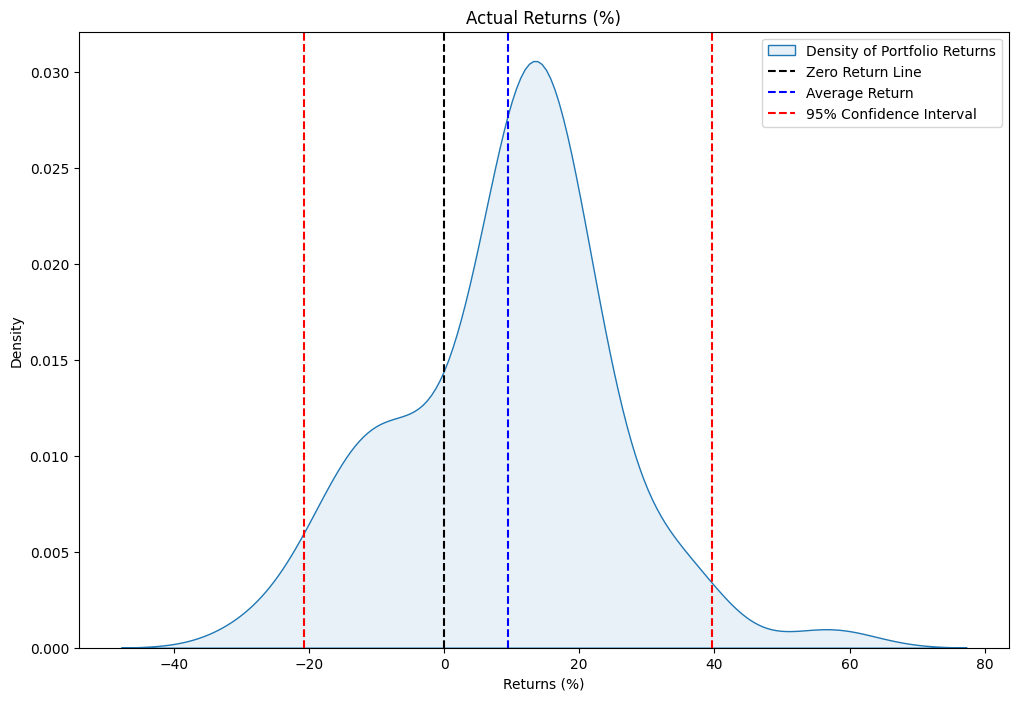

In [117]:
# make density plot of the returns of the test 9 portfolio
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.kdeplot(data=LSTM_results_10, x='Actual Returns (%)', fill=True, alpha=0.1)
# make 0 vertical line
plt.axvline(x=0, color='black', linestyle='--')
# make average return vertical line
plt.axvline(x=LSTM_results_10['Actual Returns (%)'].mean(), color='blue', linestyle='--')
# include confindence interval vertical lines
plt.axvline(x=LSTM_results_10['Actual Returns (%)'].mean() + 1.96 * LSTM_results_10['Actual Returns (%)'].std(), color='r', linestyle='--')
plt.axvline(x=LSTM_results_10['Actual Returns (%)'].mean() - 1.96 * LSTM_results_10['Actual Returns (%)'].std(), color='r', linestyle='--')
plt.legend(['Density of Portfolio Returns','Zero Return Line', 'Average Return', '95% Confidence Interval'], loc='upper right')
plt.title('Actual Returns (%)')
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()

In [118]:
lowest_return_10 = LSTM_results_10['Actual Returns (%)'].min()
highest_return_10 = LSTM_results_10['Actual Returns (%)'].max()

lowest_return_date_10 = LSTM_results_10[LSTM_results_10['Actual Returns (%)'] == lowest_return_10].index[0]
highest_return_date_10 = LSTM_results_10[LSTM_results_10['Actual Returns (%)'] == highest_return_10].index[0]

print(f"Test 10 Lowest Return: {lowest_return_10} on date: {lowest_return_date_10}")
print(f"Test 10 Highest Return: {highest_return_10} on date: {highest_return_date_10}")


Test 10 Lowest Return: -27.639486550096994 on date: 2019-12-19 00:00:00
Test 10 Highest Return: 57.141623541253715 on date: 2019-11-13 00:00:00


In [121]:
# print the 10 highest returns
LSTM_results_10.sort_values(by=['Actual Returns (%)'], ascending=False).head(10)

,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-11-13,"['ENPH', 'A', 'WM', 'FIS', 'PLD', 'CCI', 'LNC'...","[0.42113297, 0.18154841, 0.15317473, 0.0856363...",18.705876,22.212728,57.141624
2019-11-11,"['ZTS', 'ENPH', 'BALL', 'CMG', 'LDOS', 'RL', '...","[0.37967384, 0.16275849, 0.11474537, 0.1014455...",10.758840,10.820092,36.216110
2019-11-20,"['FISV', 'ABBV', 'ENPH', 'IQV', 'WAB', 'MOH', ...","[0.28747246, 0.21938579, 0.15800285, 0.0905374...",6.189688,10.879781,35.612313
2019-11-19,"['CPRT', 'ENPH', 'AMCR', 'GPN', 'PAYX', 'VRSN'...","[0.325018524, 0.139499548, 0.118738274, 0.1030...",6.646401,11.402141,35.335646
2019-11-27,"['GNRC', 'ENPH', 'EXPE', 'NFLX', 'C', 'MPWR', ...","[0.59904742, 0.22265139, 0.0557454, 0.04523045...",13.560454,15.973024,33.177510
2019-12-05,"['ENPH', 'AMT', 'IQV', 'V', 'AWK', 'FICO', 'IN...","[0.30647002, 0.11103179, 0.09428851, 0.0854757...",10.352783,16.754523,26.000857
2019-11-14,"['GNRC', 'ANET', 'ENPH', 'CTLT', 'AJG', 'AAP',...","[0.52444091, 0.20341223, 0.08373561, 0.0668613...",10.512994,11.463757,25.146982
2019-12-03,"['VRSN', 'KO', 'ENPH', 'GOOG', 'MTCH', 'CLX', ...","[0.31173475, 0.14910003, 0.14621025, 0.1389726...",5.475571,9.726874,23.494669
2019-10-21,"['ALLE', 'LLY', 'IBM', 'LNC', 'AAPL', 'ECL', '...","[0.49837884, 0.18083239, 0.08856831, 0.0820583...",13.131974,7.816379,20.687769


In [122]:
# save results to csv
LSTM_results_10.to_csv('LSTM_sentiment_results_optimal.csv')

In [123]:
# Make a dataframe consisting of all the average returns and standard deviations of the 16 tests
average_returns = [LSTM_results_1['Actual Returns (%)'].mean(), LSTM_results_2['Actual Returns (%)'].mean(), LSTM_results_3['Actual Returns (%)'].mean(), LSTM_results_4['Actual Returns (%)'].mean(), LSTM_results_5['Actual Returns (%)'].mean(), LSTM_results_6['Actual Returns (%)'].mean(), LSTM_results_7['Actual Returns (%)'].mean(), LSTM_results_8['Actual Returns (%)'].mean(), LSTM_results_9['Actual Returns (%)'].mean(), LSTM_results_10['Actual Returns (%)'].mean(), LSTM_results_11['Actual Returns (%)'].mean(), LSTM_results_12['Actual Returns (%)'].mean(), LSTM_results_13['Actual Returns (%)'].mean(), LSTM_results_14['Actual Returns (%)'].mean(), LSTM_results_15['Actual Returns (%)'].mean(), LSTM_results_16['Actual Returns (%)'].mean()]
# Make a dataframe consisting of all the average expected returns and standard deviations of the 16 tests
average_expected_returns = [LSTM_results_1['Estimated Return (%)'].mean(), LSTM_results_2['Estimated Return (%)'].mean(), LSTM_results_3['Estimated Return (%)'].mean(), LSTM_results_4['Estimated Return (%)'].mean(), LSTM_results_5['Estimated Return (%)'].mean(), LSTM_results_6['Estimated Return (%)'].mean(), LSTM_results_7['Estimated Return (%)'].mean(), LSTM_results_8['Estimated Return (%)'].mean(), LSTM_results_9['Estimated Return (%)'].mean(), LSTM_results_10['Estimated Return (%)'].mean(), LSTM_results_11['Estimated Return (%)'].mean(), LSTM_results_12['Estimated Return (%)'].mean(), LSTM_results_13['Estimated Return (%)'].mean(), LSTM_results_14['Estimated Return (%)'].mean(), LSTM_results_15['Estimated Return (%)'].mean(), LSTM_results_16['Estimated Return (%)'].mean()]

index = ['cycl_1DH', 'cycl_1Dh', 'cycl_1dH', 'cycl_1dh', 'cycl_2DH', 'cycl_2Dh',
       'cycl_2dH', 'cycl_2dh', 'plat_1DH', 'plat_1Dh', 'plat_1dH', 'plat_1dh',
       'plat_2DH', 'plat_2Dh', 'plat_2dH', 'plat_2dh']
# make a dictionary for each index point  of the average returns and average expected returns together in one
average_returns_expected_returns = {'Average Returns (%)': average_returns, 'Average Expected Returns (%)': average_expected_returns}

# make a dataframe of the average returns and average expected returns
average_returns_expected_returns_df = pd.DataFrame(average_returns_expected_returns, index=index)

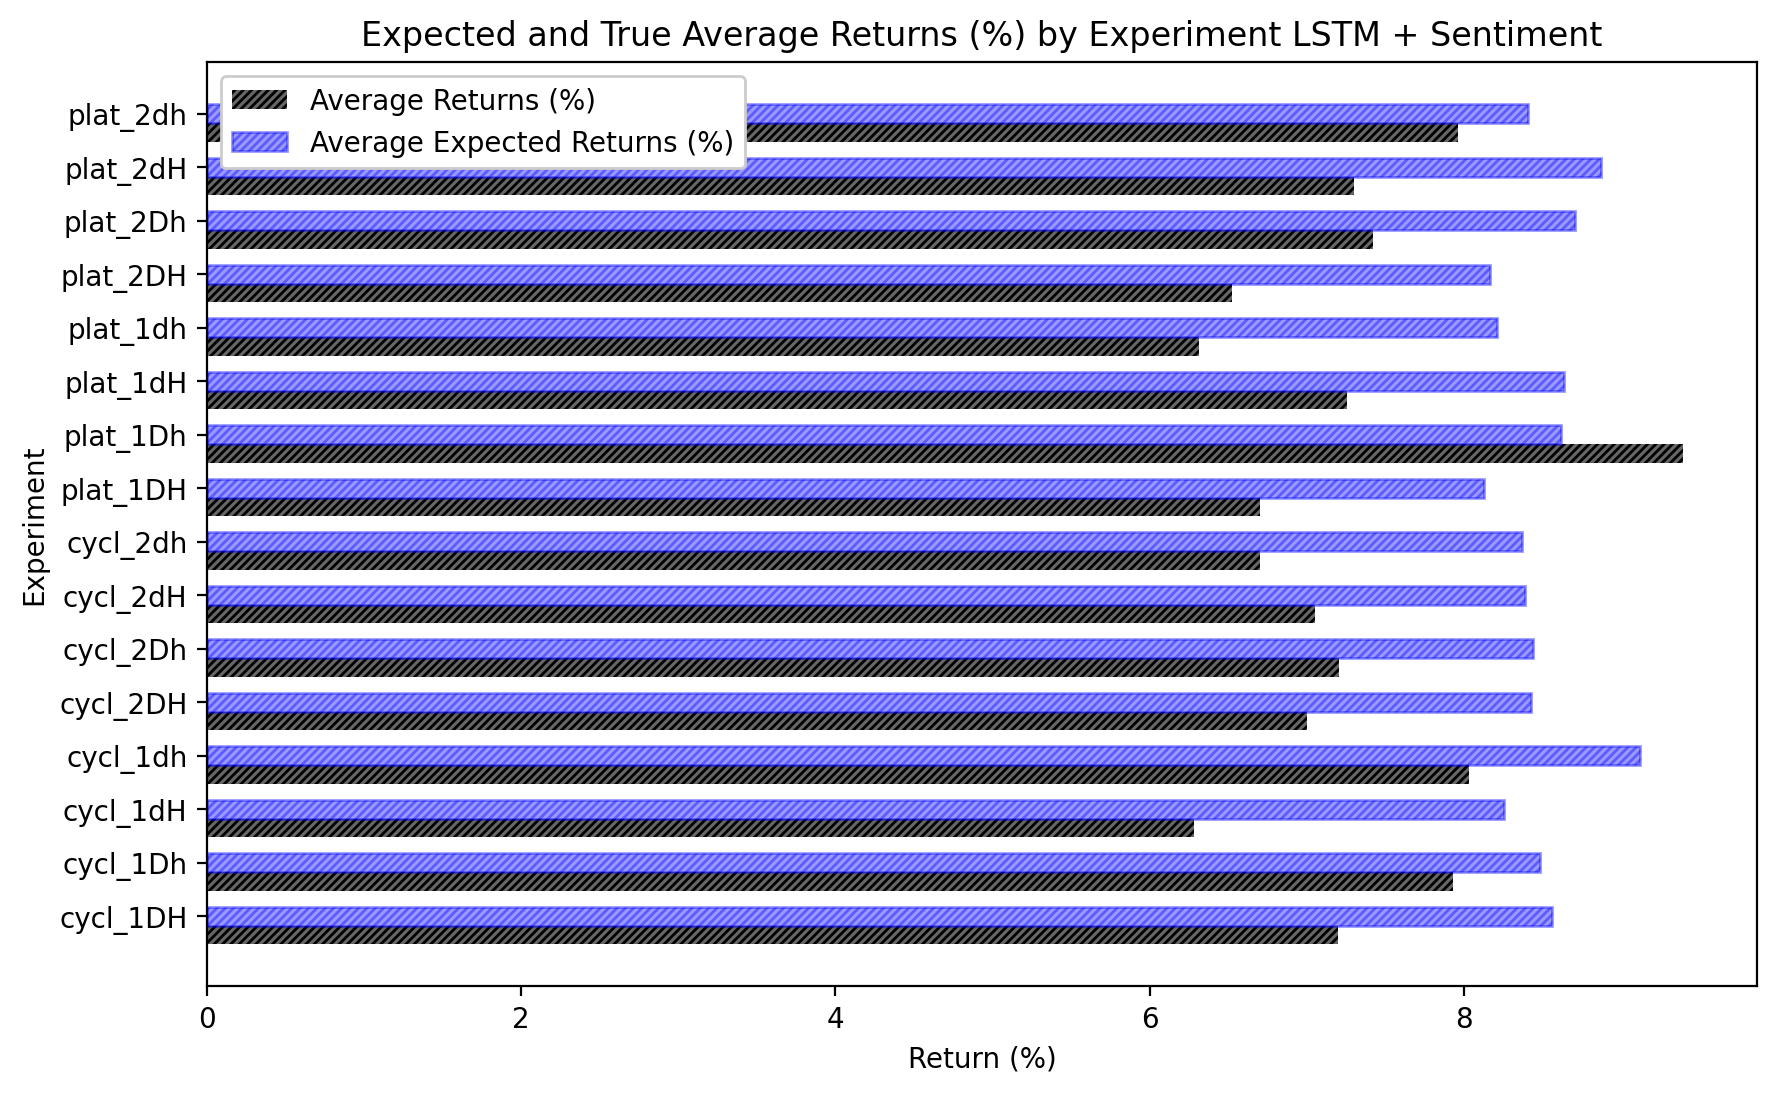

In [161]:
import numpy as np
plt.figure(figsize=(10, 6), dpi=200)

#Create an array with the position of each bar along the x-axis
barWidth = 0.35
r1 = np.arange(len(average_returns_expected_returns_df['Average Returns (%)']))
r2 = [x + barWidth for x in r1]

#Plot 'train_loss'
plt.barh(r1, average_returns_expected_returns_df['Average Returns (%)'], color='black', height=barWidth, label='Average Returns (%)', alpha=0.6,hatch='////////')

#Plot 'val_loss'
plt.barh(r2, average_returns_expected_returns_df['Average Expected Returns (%)'], color='blue', height=barWidth, label='Average Expected Returns (%)', alpha=0.4,hatch='////////',  edgecolor = 'blue')

#Adding xticks
plt.yticks([r + barWidth for r in range(len(average_returns_expected_returns_df['Average Returns (%)']))], average_returns_expected_returns_df.index)

plt.xlabel('Return (%)')  # Set the x-axis label
plt.ylabel('Experiment')  # Set the y-axis label
plt.title('Expected and True Average Returns (%) by Experiment LSTM + Sentiment')  # Set the chart title
# make legend background less transparent
plt.legend(loc='upper left',framealpha=1)


plt.show() 